### A comparison of DM and EOTest bias and offset corrections

#### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

# eotest imports
import lsst.eotest.image_utils as imutil

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [4]:
## Project an image across rows and columms
def project(image):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
    imarr = image.getArray()
    ny, nx = imarr.shape
    rows = np.arange(ny)
    cols = np.arange(nx)
    mean_over_cols = np.mean(imarr, axis=1)
    mean_over_rows = np.mean(imarr, axis=0)
    ax1.plot(rows, mean_over_cols, '.')
    ax2.plot(cols, mean_over_rows, '.')
    
    ax1.set_xlabel('Rows')
    ax1.set_ylabel('Mean counts')
    ax2.set_xlabel('Columns')
    
    plt.tight_layout()
    plt.show()
    
## These methods will be used for the EOTest analysis
## Generate a superbias frame, which is a median stack of 39 bias and offset-corrected bias frames
def get_superbias(visits, sensor, amp):
    
    n = len(visits)

    images = []
    for i in range(n):
        dId = {'visit': visits[i], 'detector': sensor}
        raw = butler.get('raw', **dId)
        detector = raw.getDetector()
        ## Getting all the pixels (i.e. not trimmed to just the data section)
        data_bbox =  detector[amp].getRawBBox()
        im = raw[data_bbox].getMaskedImage().getImage().clone()
        images.append(im)
    
    oscan = detector[amp].getRawHorizontalOverscanBBox()    
    unbiased = [imutil.unbias_and_trim(im0, oscan, bias_method='spline') for im0 in images]
    superbias = afwMath.statisticsStack(unbiased, afwMath.MEDIAN)
    
    return(superbias)

def eotest_unbias(raw_image, amp, bias_frame):
    
    detector = raw_image.clone().getDetector()
    data = detector[amp].getRawBBox()
    imaging =  detector[amp].getRawDataBBox()
    oscan = detector[amp].getRawHorizontalOverscanBBox()
    im = raw1.clone()[data].getMaskedImage().getImage().clone()
    unbiased = imutil.unbias_and_trim(im, oscan, imaging, bias_method='spline', bias_frame=bias_frame)
    
    return(unbiased)

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [5]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [6]:
isr = IsrTask(config=isr_config)

### Access images from the Butler

In [7]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)

## Query bias images from flat acquisition
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'FLAT'})

## Specifiy a visit/sensor/amplifier
visit = visits[0]
sensor = 2
amp = 'C16'

## We will do a bias and offset correction on a bias image
dId = {'visit': visit, 'detector': sensor}
raw1 = butler.get('raw', **dId)
bias1 = butler.get('bias', **dId)

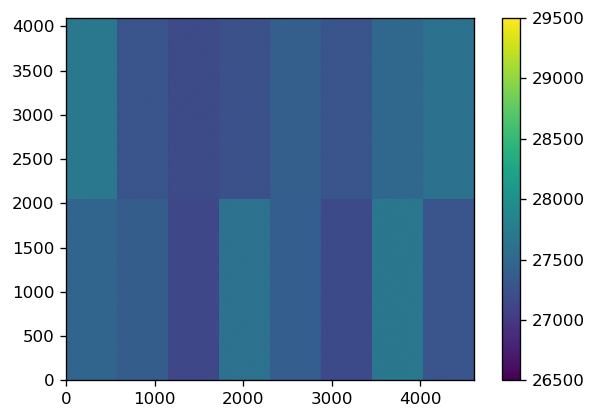

In [8]:
## What do these images look like?
plt.imshow(raw1.getImage().getArray(), origin='lower', vmin=26500, vmax=29500)
plt.colorbar()
plt.show()

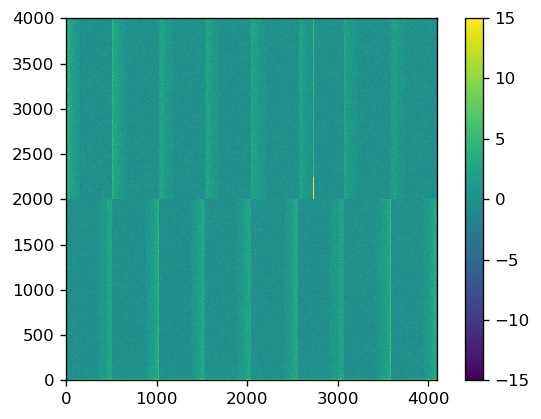

In [9]:
plt.imshow(bias1.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### Stack ISR bias/offset correction

What does the superbias look like?

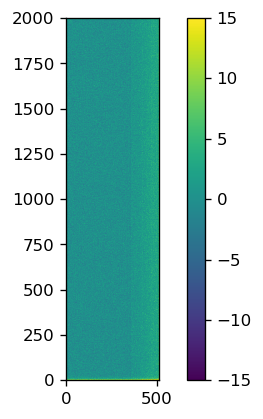

In [10]:
detector = bias1.getDetector()
amplifier = detector[amp]

## Imaging section only 
sub_im0 = bias1.getMaskedImage()[amplifier.getBBox()]

plt.imshow(sub_im0.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

What does the super bias look like along rows and columns?

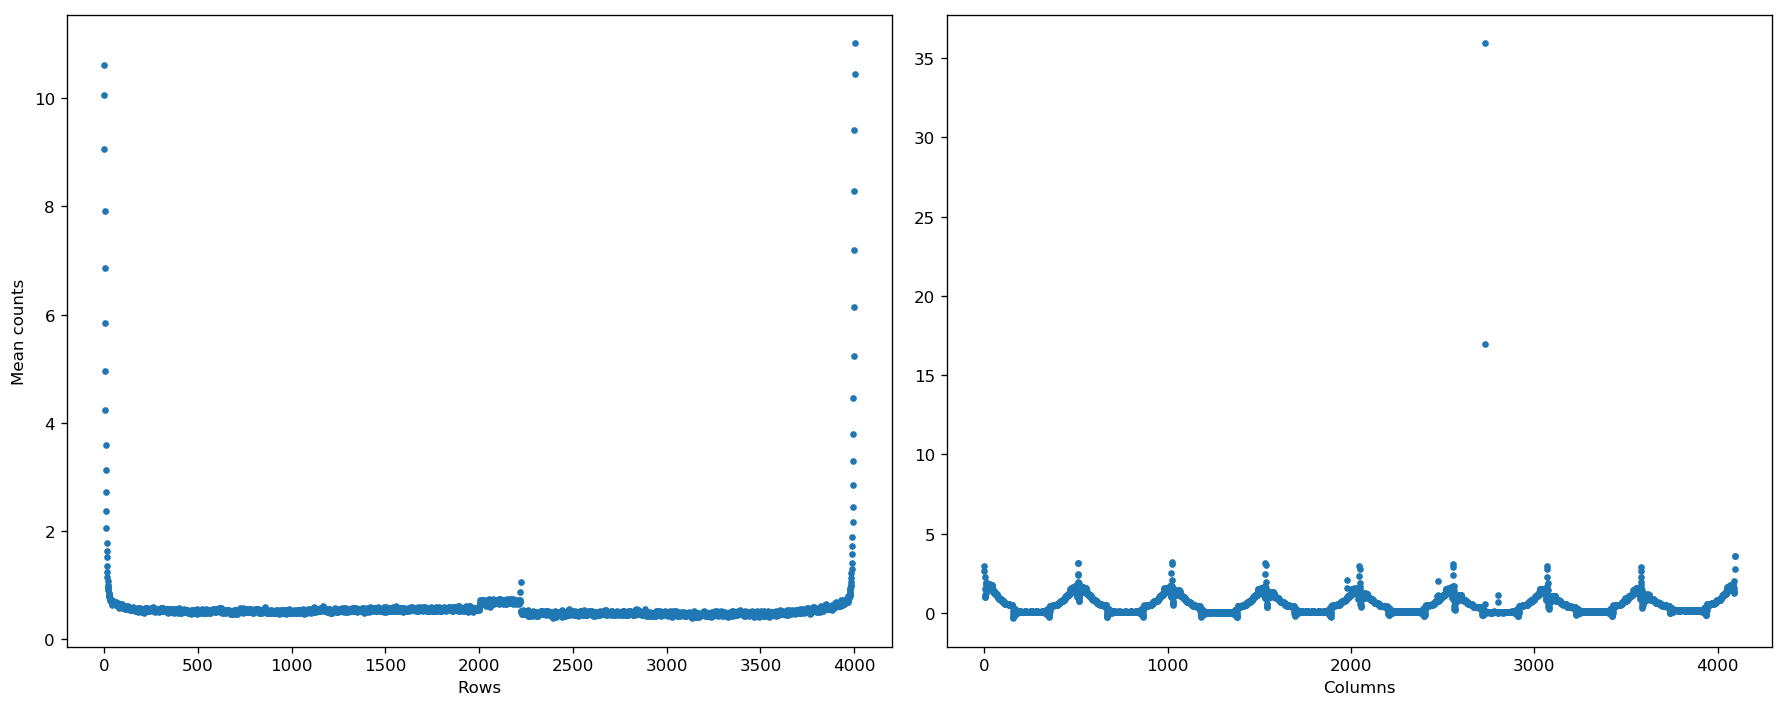

In [11]:
## Looks strange...
project(bias1.getImage())

##### Run ISR bias and offset correction

In [12]:
result1 = isr.run(raw1.clone(), bias=bias1.clone())

#### Stack bias and offset-corrected image

Since our raw image is a bias image, we expect ~zero counts in our final image.

In [13]:
## Get subimage for a specific amplifier
detector = result1.exposure.getDetector()
amplifier = detector[amp]

sub_im1 = result1.exposure.getMaskedImage()[amplifier.getBBox()]

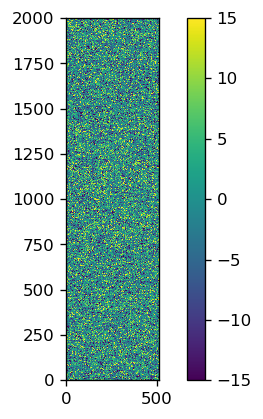

In [14]:
plt.imshow(sub_im1.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### EOTest bias/offset correction

In [15]:
superbias = get_superbias(visits, sensor, amp)

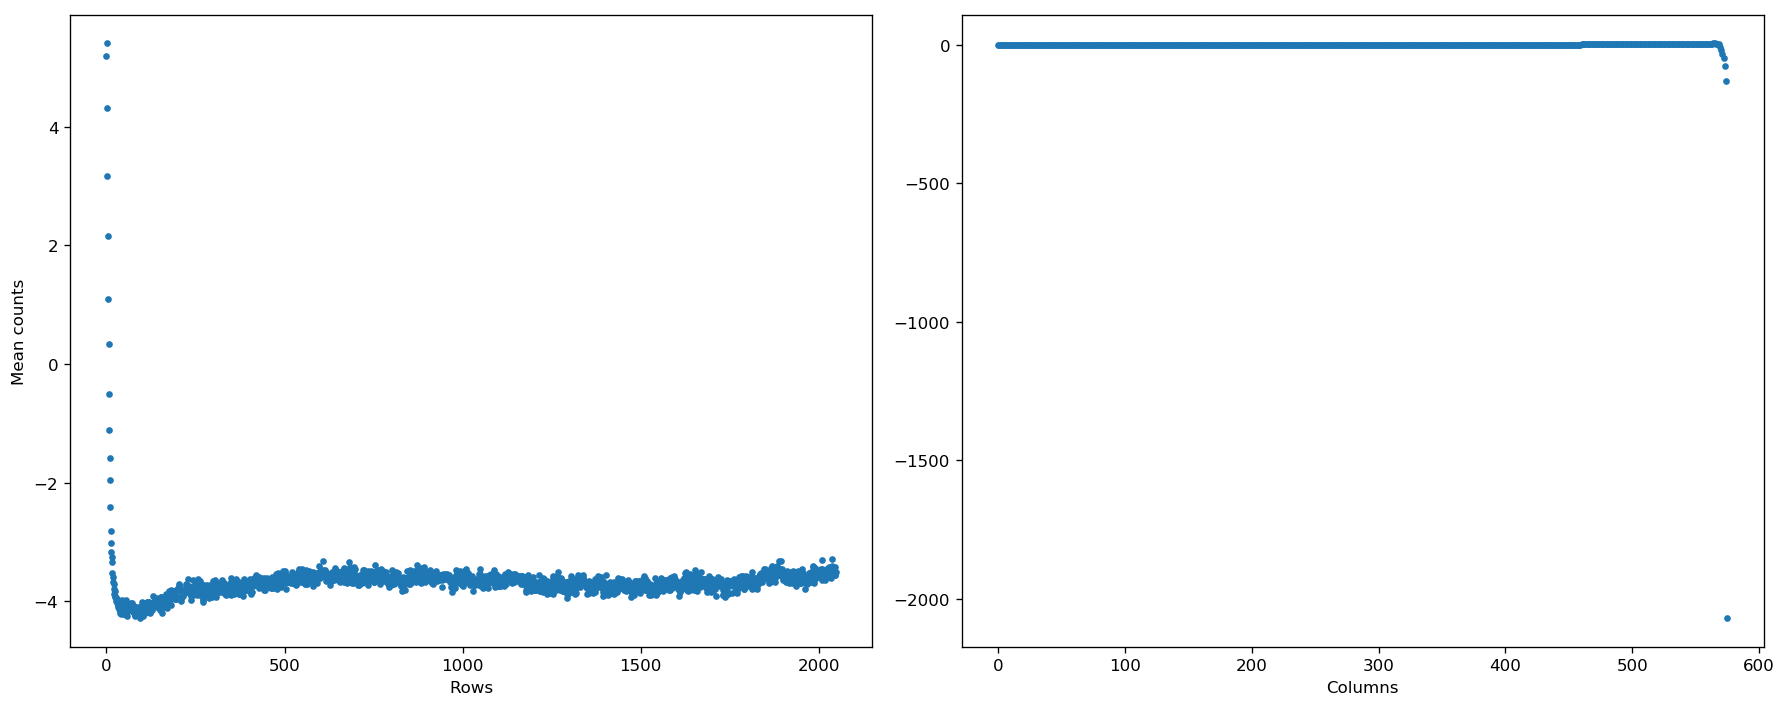

In [16]:
## Why is mean bias level around -3 along the rows?
project(superbias)

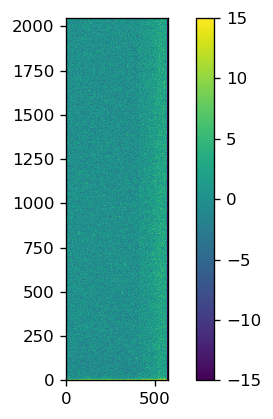

In [17]:
plt.imshow(superbias.getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

In [18]:
unbiased = eotest_unbias(raw1.clone(), amp, superbias)

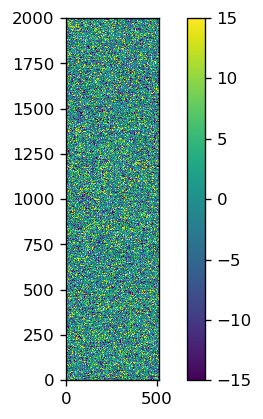

In [19]:
plt.imshow(unbiased.getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### Subtract the two overscan and bias corrected images

In [20]:
diff = unbiased.clone().getArray() - sub_im1.getImage().clone().getArray()

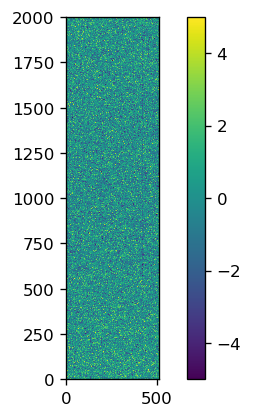

In [21]:
plt.imshow(diff, origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.show()